initial state:  [0. 0. 0. 0.]
goal:  [0. 5.]


C:\Users\zhang\AppData\Local\Temp\ipykernel_28364\613932754.py:77: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  Z = kron(np.diag(np.ones(T),-1), np.eye(nx))
C:\Users\zhang\AppData\Local\Temp\ipykernel_28364\613932754.py:80: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  A_compact = block_diag(kron(np.eye(T),A_nominal), np.zeros_like(A_nominal))
C:\Users\zhang\AppData\Local\Temp\ipykernel_28364\613932754.py:83: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  B_compact = block_diag(kron(np.eye(T),B_nominal), np.zeros_like(B_nominal))
C:\Users\zhang\AppData\Local\Temp\ipykernel_28364\613932754.py:86: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  C_compact = block_diag(

runtime: 0.871s
v star:  [2.99994247 0.88887109]
min obj:  -14.361111005403686


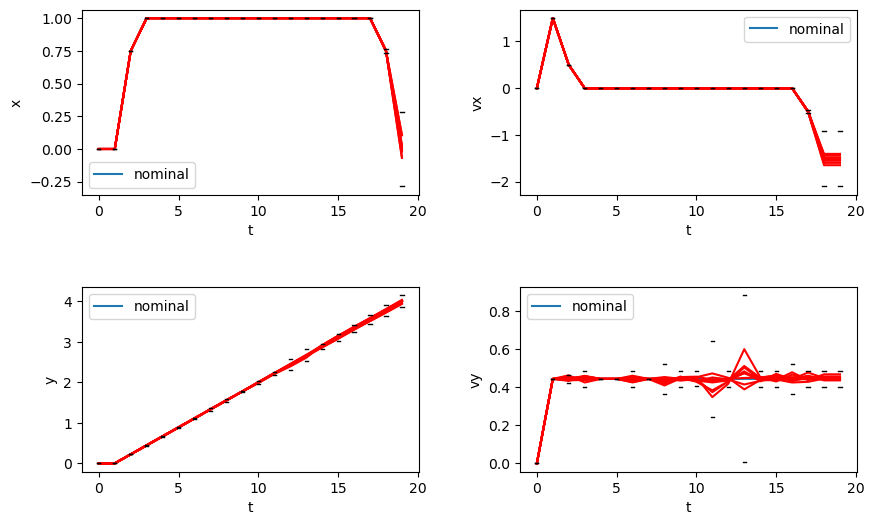

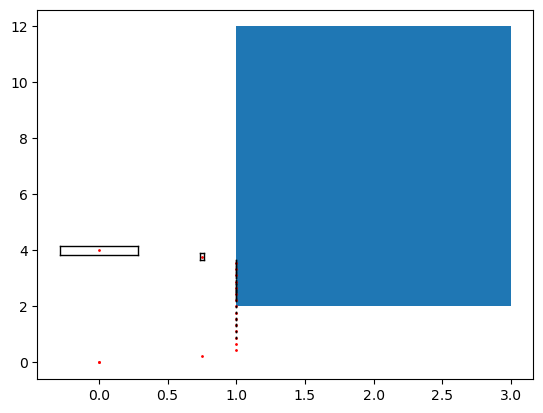

In [12]:
import numpy as np
from scipy.linalg import kron, block_diag
# import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import mosek
import cvxpy as cp
import time
# np.random.seed(0)

"""
A = [1 0 dt 0]  B = [0 0]  Bw = 0.1*I  C = [1 0 0 0]
    [0 1 0 dt]      [0 0]                  [0 1 0 0]
    [0 0 1 0]       [dt 0]
    [0 0 0 1]       [0 dt]
[dx, dy, dvx, dvy] = [0 0 1 0][x, y, vx, vy] + [0 0][ax, ay]
                     [0 0 0 1]                 [0 0]  
                     [0 0 0 0]                 [1 0]
                     [0 0 0 0]                 [0 1]
x(t+1) = Ax(t) + Bu(t) + Bw w(t)
y(t) = Cx(t) + Dy w(t)
z(t+1) = Az(t) + Bv(t)
r(t) = Cz(t)
"""

dt = 0.5
A_nominal = np.array([[1, 0, dt, 0],
                      [0, 1, 0, dt],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]], dtype=np.float32)
B_nominal = np.array([[0, 0],
                      [0, 0],
                      [dt, 0],
                      [0, dt]], dtype=np.float32)
C_nominal = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0]], dtype=np.float32)
nx = 4
nu = 2
ny = 2
delta_A = np.zeros_like(A_nominal)
delta_B = np.zeros_like(B_nominal)

A = A_nominal + delta_A
B = B_nominal + delta_B
Dx = np.eye(nx)*0.0
Dy = 0.01 * np.array([[1, 0, 0, 0],
               [0, 1, 0, 0]], dtype=np.float32)

# choose x(0) from [-10,10]
x_init = (np.random.random(nx) - 0.5) * 20.
x_init[0] = 0.
x_init[1] = 0.
x_init[2] = 0
x_init[3] = 0
P_init = np.zeros((nx,nx))
y_max = 11.
y_min = -1.
# v_max = 1.5
# v_min = -1.5
y_terminal_max = 10
y_terminal_min = -10
u_max = 2.
u_min = -2.
# v_terminal_max = 0.1
# v_terminal_min = -0.1
goal = np.array([0, 5.], dtype=np.float32)

T = 19

print("initial state: ", x_init)
print("goal: ", goal)

# obstacle
obs_low_left = (1., 2.)
obs_width = 2.

Z = kron(np.diag(np.ones(T),-1), np.eye(nx))
# print(Z)

A_compact = block_diag(kron(np.eye(T),A_nominal), np.zeros_like(A_nominal))
# print(A_compact.shape)
# print(A_compact)
B_compact = block_diag(kron(np.eye(T),B_nominal), np.zeros_like(B_nominal))
# print(B_compact.shape)
# print(B_compact)
C_compact = block_diag(kron(np.eye(T),C_nominal), np.zeros_like(C_nominal))

ZA = Z @ A_compact
# print(ZA.shape)
# print(ZA)
ZB = Z @ B_compact
# print(ZB.shape)
# print(ZB)

Id = np.eye((T+1)*nx)

# Sigma = block_diag(np.eye(nx), kron(np.eye(T), Bw))
# print(Sigma)

# system responses
phi_xx = cp.Variable(((T+1)*nx, (T+1)*nx))
phi_xy = cp.Variable(((T+1)*nx, (T+1)*ny))
phi_ux = cp.Variable(((T+1)*nu, (T+1)*nx))
phi_uy = cp.Variable(((T+1)*nu, (T+1)*ny))
z = cp.Variable((T+1, nx))
v = cp.Variable((T, nu))
scale = 1e2  # a large constant
collision = cp.Variable((T+1, 4), boolean=True)
goal = cp.Parameter(ny, value=goal)

# objective
obj = 0
for t in range(T):
    obj = obj + cp.square((cp.norm(C_nominal@(z[t+1,:]-z[t,:]))))
    obj = obj - z[t,0]  # penalize x(t) to be zero
# obj = obj + 2*cp.square(cp.norm(C_nominal@z[-1,:] - goal))
# for i in range(T):
#     for j in range(i+1):
#         obj = obj + cp.square(cp.norm(phi_xx[i*nx:(i+1)*nx, j*nx:(j+1)*nx], p='inf')) + \
#                     cp.square(cp.norm(phi_xy[i*nx:(i+1)*nx, j*ny:(j+1)*ny], p='inf')) + \
#                     cp.square(cp.norm(phi_ux[i*nu:(i+1)*nu, j*nx:(j+1)*nx], p='inf')) + \
#                     cp.square(cp.norm(phi_uy[i*nu:(i+1)*nu, j*ny:(j+1)*ny], p='inf'))
obj = cp.Minimize(obj)

# constraints
constr = []
constr.append(((Id-ZA) @ phi_xx - ZB @ phi_ux) == Id)
constr.append(((Id-ZA) @ phi_xy - ZB @ phi_uy) == np.zeros(((T+1)*nx, (T+1)*ny)))
constr.append((phi_xx@(Id-ZA) - phi_xy@C_compact) == Id)
constr.append((phi_ux@(Id-ZA) - phi_uy@C_compact) == np.zeros(((T+1)*nu, (T+1)*nx)))
for i in range(T):
    constr.append(phi_xx[i*nx:(i+1)*nx, (i+1)*nx:] == np.zeros((nx, (T-i)*nx)))
    constr.append(phi_ux[i*nu:(i+1)*nu, (i+1)*nx:] == np.zeros((nu, (T-i)*nx)))
    constr.append(phi_xy[i*nx:(i+1)*nx, (i+1)*ny:] == np.zeros((nx, (T-i)*ny)))
    constr.append(phi_uy[i*nu:(i+1)*nu, (i+1)*ny:] == np.zeros((nu, (T-i)*ny)))

# nominal dynamics constraint
constr.append(z[0,:] == x_init)
# constr.append(z[-1,0] <= 0.1)
# constr.append(z[-1,0] >= -0.1)
constr.append(z[-1,0]  == 0)

# constr.append(z[-1,1] <= 4.1)
# constr.append(z[-1,1] >= 3.9)
constr.append(z[-1,1]  == 4)

for i in range(T):
    constr.append(z[i+1,:] == (A_nominal@z[i,:] + B_nominal@v[i,:]))

# obstacle avoidance
for i in range(T+1):
    delta_max_i = cp.abs(C_nominal@phi_xx[i*nx:(i+1)*nx, :nx]@P_init).sum(axis=1) + \
                    cp.abs(C_nominal@phi_xy[i*nx:(i+1)*nx, :ny]@Dy).sum(axis=1) #+ cp.abs(Dy).sum(axis=1)
    # for j in range(1,T+1):
    for j in range(1,i+1):
        # delta_max_i = delta_max_i + cp.abs(phi_x[i*nx:(i+1)*nx, j*nx:(j+1)*nx]).sum(axis=1)
        delta_max_i = delta_max_i + cp.abs(C_nominal@phi_xx[i*nx:(i+1)*nx, j*nx:(j+1)*nx]@Dx).sum(axis=1) + \
                                    cp.abs(C_nominal@phi_xy[i*nx:(i+1)*nx, j*ny:(j+1)*ny]@Dy).sum(axis=1) + \
                                    0#cp.abs(Dy).sum(axis=1)
    
    cond1 = (z[i,0] + delta_max_i[0]) - obs_low_left[0]

    constr.append(cond1 <= 0)
    # constr.append(cond1 <= scale*collision[i,0])
    # constr.append(cond2 <= scale*collision[i,1])
    # constr.append(cond3 <= scale*collision[i,2])
    # constr.append(cond4 <= scale*collision[i,3])
    # constr.append(cp.sum(collision[i]) <= 3)

# # output constraint
# Fy = np.array([[1,0], [-1,0],
#                [0,1], [0,-1]])
# by = np.array([y_max, -y_min, y_max, -y_min])
# for i in range(T):
#     for j in range(len(by)):
#         f = Fy[j,:].reshape(1,-1)
#         b = by[j]
#         lhs = f@C_nominal@z[i,:] + cp.norm(f@C_nominal@phi_xx[i*nx:(i+1)*nx, :nx]@P_init, p='inf') + \
#                 cp.norm(f@C_nominal@phi_xy[i*nx:(i+1)*nx, :ny], p='inf') #+ cp.norm(f@Dy, p='inf')
#         for k in range(1,i+1):
#             lhs = lhs + cp.norm(f@C_nominal@phi_xx[i*nx:(i+1)*nx, k*nx:(k+1)*nx]@Dx, p='inf') + \
#                         cp.norm(f@C_nominal@phi_xy[i*nx:(i+1)*nx, k*ny:(k+1)*ny]@Dy, p='inf') + \
#                         0#cp.norm(f@Dy, p='inf')
#         constr.append(lhs <= b)

# terminal constraint
# Ft = np.array([[1,0,0,0],[-1,0,0,0],
#                [0,1,0,0],[0,-1,0,0],
#                [0,0,1,0],[0,0,-1,0],
#                [0,0,0,1],[0,0,0,-1]])
# bt = np.array([x_terminal_max, -x_terminal_min, x_terminal_max, -x_terminal_min,
#                v_terminal_max, -v_terminal_min, v_terminal_max, -v_terminal_min])
# Ft = np.array([[1,0], [-1,0],
#                [0,1], [0,-1]])
# bt = np.array([1])
# for i in range(len(bt)):
#     f = Ft[i,:].reshape(1,-1)
#     b = bt[i]
#     lhs = f@C_nominal@z[-1,:] + cp.norm(f@C_nominal@phi_xx[T*nx:, :nx]@P_init, p='inf') + \
#             cp.norm(f@C_nominal@phi_xy[T*nx:, :ny]@Dy, p='inf') #+ cp.norm(f@Dy, p='inf')
#     for k in range(1,T+1):
#         lhs = lhs + cp.norm(f@C_nominal@phi_xx[T*nx:, k*nx:(k+1)*nx]@Dx, p='inf') + \
#                         cp.norm(f@C_nominal@phi_xy[T*nx:, k*ny:(k+1)*ny]@Dy, p='inf') + \
#                         0#cp.norm(f@Dy, p='inf')
#     constr.append(lhs <= b)

# input constraint
# Fu = np.array([[1,0],[-1,0],
#               [0,1],[0,-1]])
# bu = np.array([u_max, -u_min, u_max, -u_min])
# for i in range(T):
#     for j in range(len(bu)):
#         f = Fu[j,:].reshape(1,-1)
#         b = bu[j]
#         # lhs = f@v[i,:] + cp.norm(f@C_nominal@phi_ux[i*nu:(i+1)*nu, :nx]@P_init, p='inf') + cp.norm(f@Dy, p='inf')
#         lhs = f@v[i,:]  + cp.norm(f@phi_uy[i*nu:(i+1)*nu, :ny]@Dy, p='inf')
#         for k in range(1,i+1):
#             lhs = lhs + cp.norm(f@phi_ux[i*nu:(i+1)*nu, k*nx:(k+1)*nx]@Dx, p='inf') + \
#                         cp.norm(f@phi_uy[i*nu:(i+1)*nu, k*ny:(k+1)*ny]@Dy, p='inf')
#         constr.append(lhs <= b)

problem = cp.Problem(obj, constr)
# result = problem.solve(solver=cp.MOSEK, verbose=False)
start = time.perf_counter()
result = problem.solve(solver=cp.GUROBI)
end = time.perf_counter()
print("runtime: {:.3f}s".format(end-start))

# K = phi_u.value @ np.linalg.inv(phi_x.value)
# print("Controller: ", K)

# trajectory
v_star = v.value[0,:]
print("v star: ", v_star)
print("min obj: ", obj.value)
# disturbance = np.zeros((T+1, nx))
# delta_x = np.zeros((T+1, nx))
# for i in range(1, T+1):
#     disturbance[i] = (np.random.random(nx)-0.5) 
#     disturbance[i] = np.random.random()*disturbance[i]/np.linalg.norm(disturbance[i])
#     # print(np.linalg.norm(disturbance[i]))
# print("disturbance: ", disturbance)
# for i in range(T):
#     print("-----------------")
#     print("nominal state ", i, ": ", z.value[i,:])
#     print("nominal input ", i, ": ", v.value[i,:])
#     delta_x_i = np.zeros(nx)
#     for j in range(T+1):
#         delta_x_i += phi_x.value[i*nx:(i+1)*nx, j*nx:(j+1)*nx]@disturbance[j,:]
#     delta_x[i] = delta_x_i
#     print("actual state ", i, ": ", z.value[i,:]+delta_x_i)
#     print("-----------------")
# print("nominal state ", T, ": ", z.value[-1,:])
# delta_x_T = np.zeros(nx)
# for j in range(T+1):
#     delta_x_T += phi_x.value[T*nx:, j*nx:(j+1)*nx]@disturbance[j,:]
# delta_x[T] = delta_x_T
# print("actual state ", T, ": ", z.value[-1,:]+delta_x_T)

# tube boundary
# max_disturbance = np.ones((T+1, nx))
# max_disturbance[0,:] = np.zeros(nx)
# delta_max = np.zeros((T+1, nx))
# for i in range(T+1):
#     tmp = np.zeros(nx)
#     for j in range(T+1):
#         tmp += phi_x.value[i*nx:(i+1)*nx, j*nx:(j+1)*nx]@max_disturbance[j,:]
#     delta_max[i] = tmp

delta_max = np.zeros((T+1, nx))
for i in range(T+1):
    delta_max_i = np.zeros(nx)
    for j in range(1,T+1):
        delta_max_i = delta_max_i + np.abs(phi_xx.value[i*nx:(i+1)*nx, j*nx:(j+1)*nx]@Dx).sum(axis=1) + \
                                    np.abs(phi_xy.value[i*nx:(i+1)*nx, j*ny:(j+1)*ny]@Dy).sum(axis=1) 
    delta_max[i] = delta_max_i

# for i in range(T+1):
#     for j in range(T+1):
#         print(phi_x.value[i*nx:(i+1)*nx, j*nx:(j+1)*nx])

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

def plot_state(ax, idx, y_label):
    ax.plot(np.arange(T+1), z.value[:,idx], label="nominal")

    # actual (sample some disturbance)
    for _ in range(10):
        disturbance = np.zeros((T+1, nx))
        delta = np.zeros((T+1, nx))
        for i in range(1, T+1):
            disturbance[i] = (np.random.random(nx)-0.5) 
            disturbance[i] = np.random.random()*disturbance[i]/np.linalg.norm(disturbance[i], ord=np.inf)
        for i in range(T+1):
            delta_i = np.zeros(nx)
            for j in range(1,T+1):
                delta_i = delta_i + phi_xx.value[i*nx:(i+1)*nx, j*nx:(j+1)*nx]@Dx@disturbance[j,:] + \
                                    phi_xy.value[i*nx:(i+1)*nx, j*ny:(j+1)*ny]@Dy@disturbance[j,:] 
            delta[i] = delta_i

        ax.plot(np.arange(T+1), z.value[:,idx]+delta[:,idx], c='r') #, label="actual")
    
    for t in range(T+1):
        ax.plot([t-0.1, t+0.1], [z.value[t,idx]+delta_max[t,idx], z.value[t,idx]+delta_max[t,idx]], 'k-', linewidth=1)
        ax.plot([t-0.1, t+0.1], [z.value[t,idx]-delta_max[t,idx], z.value[t,idx]-delta_max[t,idx]], 'k-', linewidth=1)

    ax.legend()
    ax.set_xlabel("t")
    ax.set_ylabel(y_label)

# x
plot_state(axes[0][0], 0, "x")

# vx
plot_state(axes[0][1], 2, "vx")

# y
plot_state(axes[1][0], 1, "y")

# vy
plot_state(axes[1][1], 3, "vy")

# plt.savefig("phases")
plt.show()

# plt.cla()

fig, ax = plt.subplots()
obs = patches.Rectangle(obs_low_left, obs_width, 10)
ax.add_patch(obs)
ax.scatter(z.value[:,0], z.value[:,1], s=1, c='r')
for t in range(T+1):
    ax.plot([z.value[t,0]-delta_max[t,0], z.value[t,0]-delta_max[t,0]], [z.value[t,1]-delta_max[t,1], z.value[t,1]+delta_max[t,1]], 'k-', linewidth=1)
    ax.plot([z.value[t,0]+delta_max[t,0], z.value[t,0]+delta_max[t,0]], [z.value[t,1]-delta_max[t,1], z.value[t,1]+delta_max[t,1]], 'k-', linewidth=1)
    ax.plot([z.value[t,0]-delta_max[t,0], z.value[t,0]+delta_max[t,0]], [z.value[t,1]-delta_max[t,1], z.value[t,1]-delta_max[t,1]], 'k-', linewidth=1)
    ax.plot([z.value[t,0]-delta_max[t,0], z.value[t,0]+delta_max[t,0]], [z.value[t,1]+delta_max[t,1], z.value[t,1]+delta_max[t,1]], 'k-', linewidth=1)
# plt.savefig("traj")
plt.show()


In [13]:
z.value[:,0:2]


array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.74998562, 0.22221777],
       [1.        , 0.44447585],
       [1.        , 0.66668942],
       [1.        , 0.88890028],
       [1.        , 1.11111134],
       [1.        , 1.33332329],
       [0.99999999, 1.55554042],
       [0.99999999, 1.77776014],
       [0.99999999, 1.99998656],
       [0.99999999, 2.22221911],
       [0.99999999, 2.44445778],
       [0.99999999, 2.6666739 ],
       [0.99999999, 2.8889182 ],
       [0.99999999, 3.11114095],
       [0.99999999, 3.3333524 ],
       [0.99999998, 3.5555612 ],
       [0.74997763, 3.77777623],
       [0.        , 4.        ]])

In [14]:
Z


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(80, 80))